# Regularização da Série Temporal WS100

Este notebook corrige intervalos irregulares na série temporal WS100.csv, garantindo que todos os timestamps tenham exatamente 10 minutos de diferença entre si. Intervalos irregulares podem causar problemas na aplicação de filtros de Kalman e outros modelos de séries temporais.

In [1]:
# Importação das bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import timedelta
import warnings

# Configurações
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')

print("Bibliotecas importadas com sucesso.")

Bibliotecas importadas com sucesso.


In [2]:
# Carregamento dos dados WS100
input_file = Path('../converted_csv_data/WS100.csv')
print(f"Carregando dados de: {input_file}")

if not input_file.exists():
    raise FileNotFoundError(f"Arquivo não encontrado: {input_file}")

# Carregamento dos dados
df = pd.read_csv(input_file)
df['DT'] = pd.to_datetime(df['DT'])

print(f"Shape dos dados originais: {df.shape}")
print(f"Período: {df['DT'].min()} a {df['DT'].max()}")
print(f"Total de valores NaN: {df['SODAR-100'].isna().sum()}")

# Análise inicial da regularidade temporal
df_sorted = df.sort_values('DT').reset_index(drop=True)
time_diffs = df_sorted['DT'].diff().dropna()
expected_interval = timedelta(minutes=10)

# Identificação de intervalos irregulares
irregular_intervals = time_diffs[time_diffs != expected_interval]
regular_intervals = time_diffs[time_diffs == expected_interval]

print(f"\nAnálise da regularidade temporal:")
print(f"Intervalos regulares (10 min): {len(regular_intervals)}")
print(f"Intervalos irregulares: {len(irregular_intervals)}")
print(f"Percentual irregular: {len(irregular_intervals) / len(time_diffs) * 100:.2f}%")

if len(irregular_intervals) > 0:
    print(f"\nEstatísticas dos intervalos irregulares:")
    print(f"Menor intervalo: {irregular_intervals.min()}")
    print(f"Maior intervalo: {irregular_intervals.max()}")
    print(f"Mediana: {irregular_intervals.median()}")
    
    # Primeiros exemplos de intervalos irregulares
    print(f"\nPrimeiros 10 intervalos irregulares:")
    for i, (idx, interval) in enumerate(irregular_intervals.head(10).items()):
        prev_time = df_sorted.loc[idx-1, 'DT']
        curr_time = df_sorted.loc[idx, 'DT']
        print(f"{i+1}. {prev_time} -> {curr_time}: {interval}")

df_sorted.head()

Carregando dados de: ../converted_csv_data/WS100.csv
Shape dos dados originais: (47995, 2)
Período: 2021-11-10 17:20:00 a 2022-10-09 08:30:00
Total de valores NaN: 6921

Análise da regularidade temporal:
Intervalos regulares (10 min): 47899
Intervalos irregulares: 95
Percentual irregular: 0.20%

Estatísticas dos intervalos irregulares:
Menor intervalo: 0 days 00:00:00
Maior intervalo: 0 days 00:00:00
Mediana: 0 days 00:00:00

Primeiros 10 intervalos irregulares:
1. 2022-06-30 00:10:00 -> 2022-06-30 00:10:00: 0 days 00:00:00
2. 2022-06-30 00:10:00 -> 2022-06-30 00:10:00: 0 days 00:00:00
3. 2022-06-30 00:20:00 -> 2022-06-30 00:20:00: 0 days 00:00:00
4. 2022-06-30 00:20:00 -> 2022-06-30 00:20:00: 0 days 00:00:00
5. 2022-06-30 00:30:00 -> 2022-06-30 00:30:00: 0 days 00:00:00
6. 2022-06-30 00:30:00 -> 2022-06-30 00:30:00: 0 days 00:00:00
7. 2022-06-30 00:40:00 -> 2022-06-30 00:40:00: 0 days 00:00:00
8. 2022-06-30 00:40:00 -> 2022-06-30 00:40:00: 0 days 00:00:00
9. 2022-06-30 00:50:00 -> 202

,DT,SODAR-100
0,2021-11-10 17:20:00,5.83
1,2021-11-10 17:30:00,5.99
2,2021-11-10 17:40:00,6.67
3,2021-11-10 17:50:00,6.15
4,2021-11-10 18:00:00,5.90


In [3]:
# Identificação e categorização dos problemas temporais
print("Categorizando tipos de irregularidades...")

# Análise detalhada dos intervalos irregulares
interval_analysis = []
for idx, interval in irregular_intervals.items():
    prev_time = df_sorted.loc[idx-1, 'DT']
    curr_time = df_sorted.loc[idx, 'DT']
    
    # Cálculo em minutos
    interval_minutes = interval.total_seconds() / 60
    
    # Categorização do tipo de problema
    if interval_minutes < 10:
        problem_type = "Intervalo menor que 10 min"
    elif interval_minutes > 10 and interval_minutes < 20:
        problem_type = "Gap pequeno (10-20 min)"
    elif interval_minutes >= 20 and interval_minutes < 60:
        problem_type = "Gap médio (20-60 min)"
    elif interval_minutes >= 60 and interval_minutes < 1440:  # 1 dia
        problem_type = "Gap grande (1h-1dia)"
    else:
        problem_type = "Gap muito grande (>1 dia)"
    
    interval_analysis.append({
        'index': idx,
        'prev_time': prev_time,
        'curr_time': curr_time,
        'interval': interval,
        'interval_minutes': interval_minutes,
        'problem_type': problem_type
    })

# Conversão para DataFrame para análise
df_problems = pd.DataFrame(interval_analysis)

# Estatísticas por tipo de problema
if len(df_problems) > 0:
    problem_summary = df_problems.groupby('problem_type').agg({
        'interval_minutes': ['count', 'mean', 'min', 'max']
    }).round(2)
    
    print("\nSumarização dos problemas temporais:")
    print(problem_summary)
    
    # Identificação de timestamps duplicados
    duplicated_timestamps = df_sorted['DT'].duplicated().sum()
    print(f"\nTimestamps duplicados: {duplicated_timestamps}")
    
    if duplicated_timestamps > 0:
        print("Timestamps duplicados encontrados:")
        duplicates = df_sorted[df_sorted['DT'].duplicated(keep=False)].sort_values('DT')
        print(duplicates[['DT', 'SODAR-100']].head(10))
else:
    print("Nenhum problema temporal identificado.")

# Verificação de ordem cronológica
is_chronological = df_sorted['DT'].is_monotonic_increasing
print(f"\nDados em ordem cronológica: {is_chronological}")

if not is_chronological:
    print("Aviso: Dados não estão em ordem cronológica!")
    
df_problems.head() if len(df_problems) > 0 else print("Nenhum problema para exibir.")

Categorizando tipos de irregularidades...

Sumarização dos problemas temporais:
                           interval_minutes               
                                      count mean  min  max
problem_type                                              
Intervalo menor que 10 min               95  0.0  0.0  0.0

Timestamps duplicados: 95
Timestamps duplicados encontrados:
                       DT  SODAR-100
33305 2022-06-30 00:10:00       7.21
33306 2022-06-30 00:10:00       7.21
33307 2022-06-30 00:10:00       7.25
33308 2022-06-30 00:20:00       6.49
33309 2022-06-30 00:20:00       6.49
33310 2022-06-30 00:20:00       6.51
33311 2022-06-30 00:30:00       6.84
33312 2022-06-30 00:30:00       6.84
33313 2022-06-30 00:30:00       6.92
33316 2022-06-30 00:40:00       7.87

Dados em ordem cronológica: True


,index,prev_time,curr_time,interval,interval_minutes,problem_type
0,33306,2022-06-30 00:10:00,2022-06-30 00:10:00,0 days,0.0,Intervalo menor que 10 min
1,33307,2022-06-30 00:10:00,2022-06-30 00:10:00,0 days,0.0,Intervalo menor que 10 min
2,33309,2022-06-30 00:20:00,2022-06-30 00:20:00,0 days,0.0,Intervalo menor que 10 min
3,33310,2022-06-30 00:20:00,2022-06-30 00:20:00,0 days,0.0,Intervalo menor que 10 min
4,33312,2022-06-30 00:30:00,2022-06-30 00:30:00,0 days,0.0,Intervalo menor que 10 min


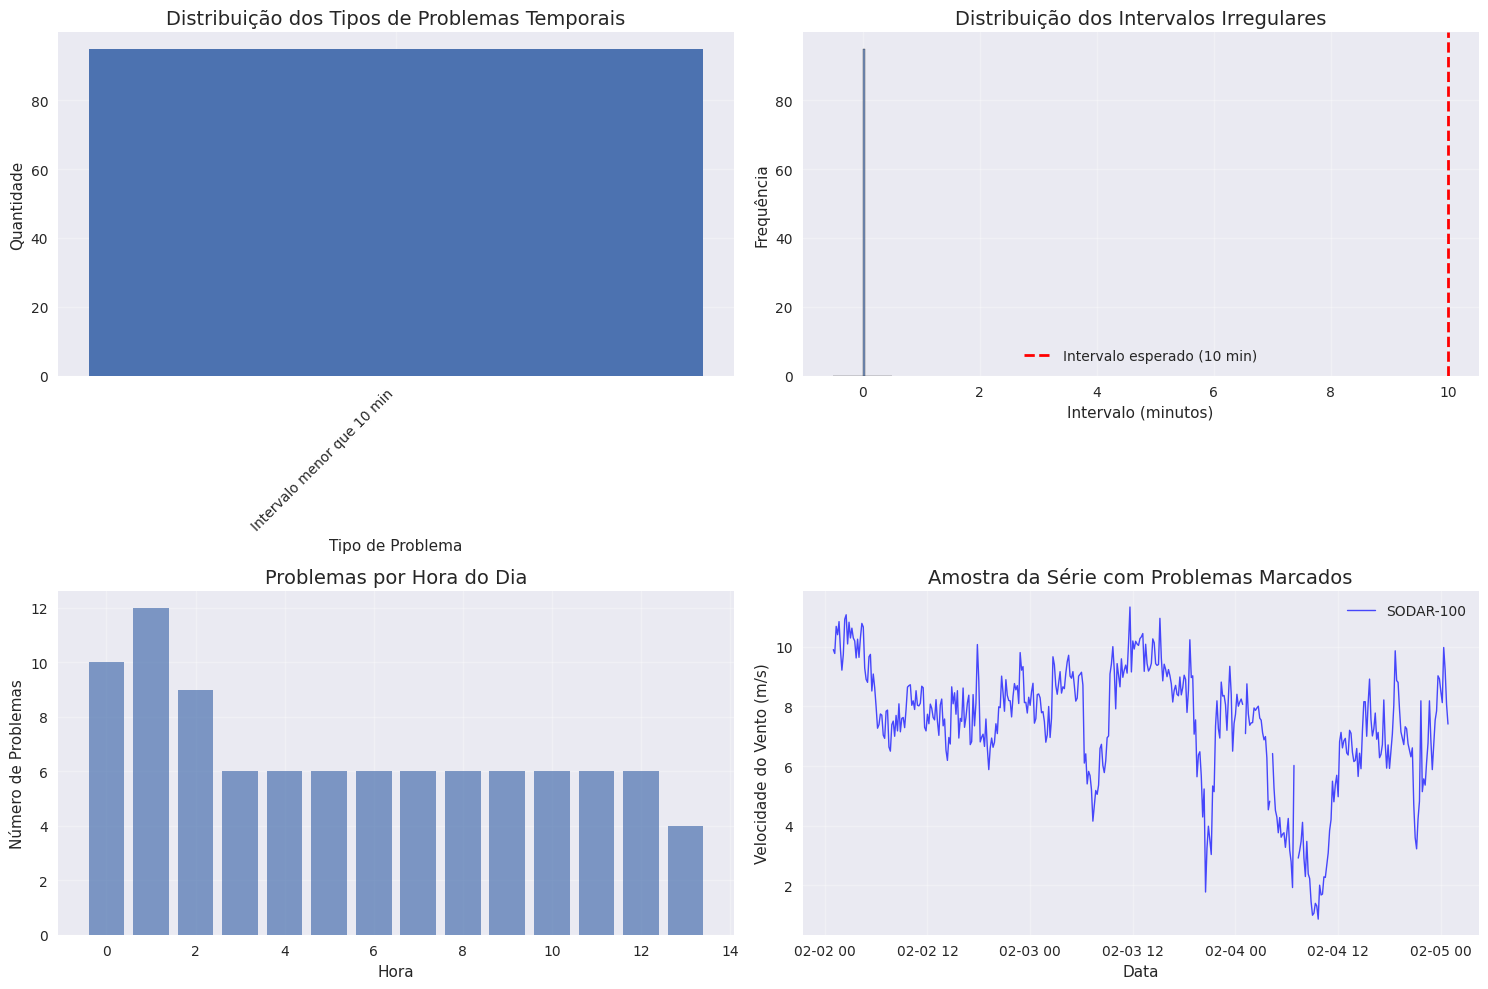

In [4]:
# Visualização dos problemas temporais
if len(df_problems) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Gráfico 1: Distribuição dos tipos de problemas
    problem_counts = df_problems['problem_type'].value_counts()
    axes[0, 0].bar(range(len(problem_counts)), problem_counts.values)
    axes[0, 0].set_title('Distribuição dos Tipos de Problemas Temporais', fontsize=14)
    axes[0, 0].set_xlabel('Tipo de Problema')
    axes[0, 0].set_ylabel('Quantidade')
    axes[0, 0].set_xticks(range(len(problem_counts)))
    axes[0, 0].set_xticklabels(problem_counts.index, rotation=45, ha='right')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Gráfico 2: Distribuição dos intervalos em minutos
    axes[0, 1].hist(df_problems['interval_minutes'], bins=30, alpha=0.7, edgecolor='black')
    axes[0, 1].axvline(x=10, color='red', linestyle='--', linewidth=2, label='Intervalo esperado (10 min)')
    axes[0, 1].set_title('Distribuição dos Intervalos Irregulares', fontsize=14)
    axes[0, 1].set_xlabel('Intervalo (minutos)')
    axes[0, 1].set_ylabel('Frequência')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Gráfico 3: Timeline dos problemas
    problem_timeline = df_problems.copy()
    problem_timeline['hour'] = problem_timeline['prev_time'].dt.hour
    problem_timeline['day'] = problem_timeline['prev_time'].dt.day
    
    hour_problems = problem_timeline.groupby('hour').size()
    axes[1, 0].bar(hour_problems.index, hour_problems.values, alpha=0.7)
    axes[1, 0].set_title('Problemas por Hora do Dia', fontsize=14)
    axes[1, 0].set_xlabel('Hora')
    axes[1, 0].set_ylabel('Número de Problemas')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Gráfico 4: Série temporal com problemas marcados
    sample_start = len(df_sorted) // 4
    sample_end = sample_start + 144 * 3  # 3 dias
    df_sample = df_sorted.iloc[sample_start:sample_end].copy()
    
    axes[1, 1].plot(df_sample['DT'], df_sample['SODAR-100'], 'b-', alpha=0.7, linewidth=1, label='SODAR-100')
    
    # Marcar pontos com problemas temporais na amostra
    sample_problems = df_problems[
        (df_problems['prev_time'] >= df_sample['DT'].min()) & 
        (df_problems['prev_time'] <= df_sample['DT'].max())
    ]
    
    if len(sample_problems) > 0:
        for _, problem in sample_problems.iterrows():
            axes[1, 1].axvline(x=problem['prev_time'], color='red', alpha=0.7, linewidth=2)
    
    axes[1, 1].set_title('Amostra da Série com Problemas Marcados', fontsize=14)
    axes[1, 1].set_xlabel('Data')
    axes[1, 1].set_ylabel('Velocidade do Vento (m/s)')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("Nenhum problema temporal para visualizar.")

In [5]:
# Processo de regularização da série temporal
print("Iniciando processo de regularização...")

# Passo 1: Remover duplicatas mantendo o primeiro registro
print("Passo 1: Removendo timestamps duplicados...")
df_clean = df_sorted.drop_duplicates(subset=['DT'], keep='first').reset_index(drop=True)
removed_duplicates = len(df_sorted) - len(df_clean)
print(f"Duplicatas removidas: {removed_duplicates}")

# Passo 2: Garantir ordem cronológica
print("Passo 2: Verificando ordem cronológica...")
df_clean = df_clean.sort_values('DT').reset_index(drop=True)
print("Dados organizados cronologicamente.")

# Passo 3: Criar grade temporal regular
print("Passo 3: Criando grade temporal regular...")
start_time = df_clean['DT'].min()
end_time = df_clean['DT'].max()

# Arredondamento do tempo inicial para múltiplo de 10 minutos
start_minute = start_time.minute
if start_minute % 10 != 0:
    # Arredondar para o próximo múltiplo de 10
    minutes_to_add = 10 - (start_minute % 10)
    start_time = start_time.replace(second=0, microsecond=0) + timedelta(minutes=minutes_to_add)
else:
    start_time = start_time.replace(second=0, microsecond=0)

# Arredondamento do tempo final para múltiplo de 10 minutos
end_minute = end_time.minute
if end_minute % 10 != 0:
    # Arredondar para baixo
    minutes_to_subtract = end_minute % 10
    end_time = end_time.replace(second=0, microsecond=0) - timedelta(minutes=minutes_to_subtract)
else:
    end_time = end_time.replace(second=0, microsecond=0)

print(f"Período regularizado: {start_time} a {end_time}")

# Criação da grade temporal regular com intervalos de 10 minutos
regular_timeline = pd.date_range(start=start_time, end=end_time, freq='10T')
print(f"Grade temporal criada: {len(regular_timeline)} pontos")

# Passo 4: Criar DataFrame regularizado
print("Passo 4: Mapeando dados para a grade regular...")
df_regular = pd.DataFrame({'DT': regular_timeline})

# Estratégia de mapeamento: Para cada timestamp regular, encontrar o dado mais próximo
df_regular['SODAR-100'] = np.nan

# Função para encontrar o valor mais próximo no tempo
def find_nearest_value(target_time, df_source, tolerance_minutes=5):
    # Encontrar diferenças temporais
    time_diffs = abs(df_source['DT'] - target_time)
    min_diff_idx = time_diffs.idxmin()
    min_diff = time_diffs.loc[min_diff_idx]
    
    # Verificar se está dentro da tolerância
    if min_diff <= timedelta(minutes=tolerance_minutes):
        return df_source.loc[min_diff_idx, 'SODAR-100']
    else:
        return np.nan

# Aplicação do mapeamento (pode ser lento para datasets grandes)
print("Mapeando valores... (pode levar alguns momentos)")
tolerance = 5  # tolerância de 5 minutos

for idx, row in df_regular.iterrows():
    if idx % 1000 == 0:
        print(f"Processando {idx}/{len(df_regular)} ({idx/len(df_regular)*100:.1f}%)")
    
    target_time = row['DT']
    nearest_value = find_nearest_value(target_time, df_clean, tolerance)
    df_regular.loc[idx, 'SODAR-100'] = nearest_value

print("Mapeamento concluído.")

# Estatísticas da regularização
original_valid = df_clean['SODAR-100'].notna().sum()
regular_valid = df_regular['SODAR-100'].notna().sum()
regular_missing = df_regular['SODAR-100'].isna().sum()

print(f"\nEstatísticas da regularização:")
print(f"Pontos originais: {len(df_clean)}")
print(f"Pontos válidos originais: {original_valid}")
print(f"Pontos na grade regular: {len(df_regular)}")
print(f"Pontos válidos mapeados: {regular_valid}")
print(f"Pontos faltantes após regularização: {regular_missing}")
print(f"Taxa de preservação: {regular_valid/original_valid*100:.1f}%")

df_regular.head()

Iniciando processo de regularização...
Passo 1: Removendo timestamps duplicados...
Duplicatas removidas: 95
Passo 2: Verificando ordem cronológica...
Dados organizados cronologicamente.
Passo 3: Criando grade temporal regular...
Período regularizado: 2021-11-10 17:20:00 a 2022-10-09 08:30:00
Grade temporal criada: 47900 pontos
Passo 4: Mapeando dados para a grade regular...
Mapeando valores... (pode levar alguns momentos)
Processando 0/47900 (0.0%)
Processando 1000/47900 (2.1%)
Processando 2000/47900 (4.2%)
Processando 3000/47900 (6.3%)
Processando 4000/47900 (8.4%)
Processando 5000/47900 (10.4%)
Processando 6000/47900 (12.5%)
Processando 7000/47900 (14.6%)
Processando 8000/47900 (16.7%)
Processando 9000/47900 (18.8%)
Processando 10000/47900 (20.9%)
Processando 11000/47900 (23.0%)
Processando 12000/47900 (25.1%)
Processando 13000/47900 (27.1%)
Processando 14000/47900 (29.2%)
Processando 15000/47900 (31.3%)
Processando 16000/47900 (33.4%)
Processando 17000/47900 (35.5%)
Processando 1800

,DT,SODAR-100
0,2021-11-10 17:20:00,5.83
1,2021-11-10 17:30:00,5.99
2,2021-11-10 17:40:00,6.67
3,2021-11-10 17:50:00,6.15
4,2021-11-10 18:00:00,5.90


Validando a regularização da série temporal...
Validação da regularidade:
Intervalos regulares (10 min): 47899
Intervalos irregulares: 0
Sucesso: Série temporal está completamente regularizada!


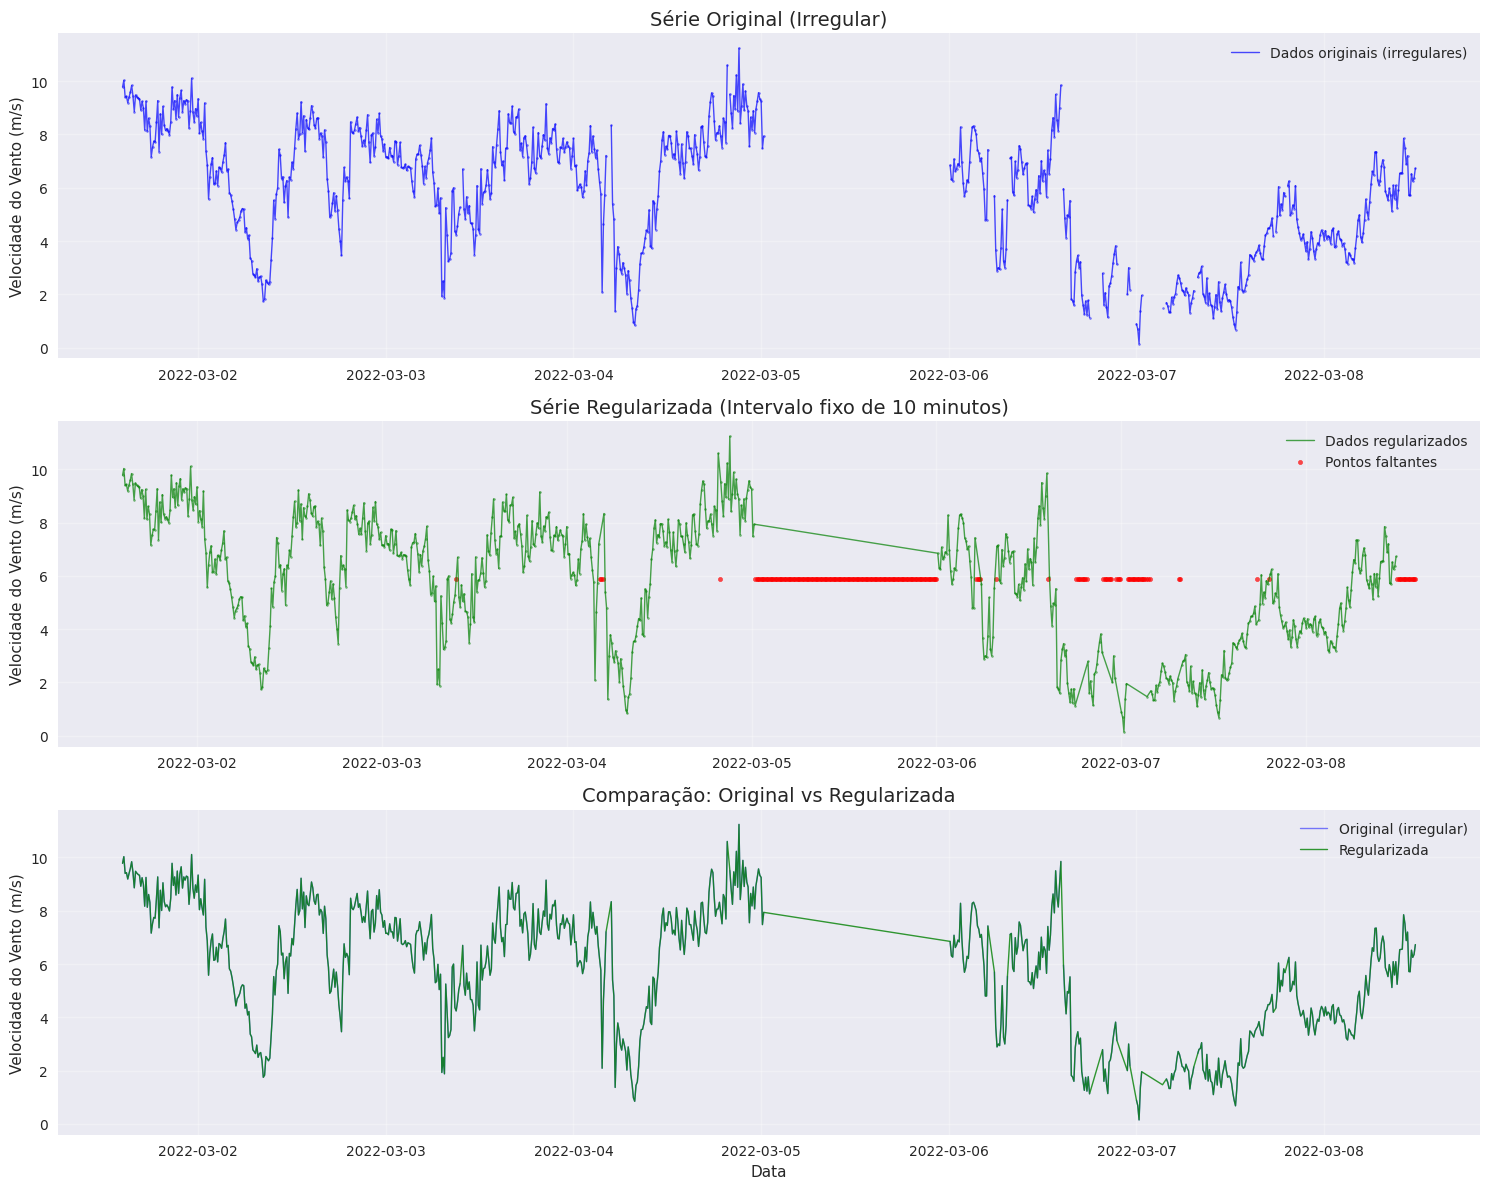


Análise de preservação dos dados:
Correlação entre séries (pontos válidos): 1.0000

Estatísticas comparativas:
Original - Média: 5.867, Std: 2.332
Regular - Média: 5.867, Std: 2.332


In [6]:
# Validação da regularização
print("Validando a regularização da série temporal...")

# Verificação da regularidade temporal
time_diffs_regular = df_regular['DT'].diff().dropna()
expected_interval = timedelta(minutes=10)

irregular_count = (time_diffs_regular != expected_interval).sum()
regular_count = (time_diffs_regular == expected_interval).sum()

print(f"Validação da regularidade:")
print(f"Intervalos regulares (10 min): {regular_count}")
print(f"Intervalos irregulares: {irregular_count}")

if irregular_count == 0:
    print("Sucesso: Série temporal está completamente regularizada!")
else:
    print(f"Aviso: Ainda existem {irregular_count} intervalos irregulares.")

# Comparação visual antes e depois
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# Seleção de uma amostra para comparação
sample_days = 7
sample_points = 144 * sample_days
start_idx = len(df_regular) // 3
end_idx = min(start_idx + sample_points, len(df_regular))

df_sample_regular = df_regular.iloc[start_idx:end_idx].copy()
sample_start_time = df_sample_regular['DT'].min()
sample_end_time = df_sample_regular['DT'].max()

# Dados originais na mesma janela temporal
df_sample_original = df_clean[
    (df_clean['DT'] >= sample_start_time) & 
    (df_clean['DT'] <= sample_end_time)
].copy()

# Gráfico 1: Dados originais (irregulares)
axes[0].plot(df_sample_original['DT'], df_sample_original['SODAR-100'], 'b-', 
             alpha=0.7, linewidth=1, label='Dados originais (irregulares)')
axes[0].scatter(df_sample_original['DT'], df_sample_original['SODAR-100'], 
                s=2, alpha=0.5, color='blue')
axes[0].set_title('Série Original (Irregular)', fontsize=14)
axes[0].set_ylabel('Velocidade do Vento (m/s)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Gráfico 2: Dados regularizados
valid_mask = df_sample_regular['SODAR-100'].notna()
axes[1].plot(df_sample_regular.loc[valid_mask, 'DT'], 
             df_sample_regular.loc[valid_mask, 'SODAR-100'], 'g-', 
             alpha=0.7, linewidth=1, label='Dados regularizados')
axes[1].scatter(df_sample_regular.loc[valid_mask, 'DT'], 
                df_sample_regular.loc[valid_mask, 'SODAR-100'], 
                s=2, alpha=0.5, color='green')

# Marcar pontos faltantes
missing_mask = df_sample_regular['SODAR-100'].isna()
if missing_mask.any():
    axes[1].scatter(df_sample_regular.loc[missing_mask, 'DT'], 
                    [df_sample_regular['SODAR-100'].mean()] * missing_mask.sum(), 
                    color='red', s=10, alpha=0.7, label='Pontos faltantes')

axes[1].set_title('Série Regularizada (Intervalo fixo de 10 minutos)', fontsize=14)
axes[1].set_ylabel('Velocidade do Vento (m/s)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Gráfico 3: Comparação sobreposta
axes[2].plot(df_sample_original['DT'], df_sample_original['SODAR-100'], 'b-', 
             alpha=0.5, linewidth=1, label='Original (irregular)')
axes[2].plot(df_sample_regular.loc[valid_mask, 'DT'], 
             df_sample_regular.loc[valid_mask, 'SODAR-100'], 'g-', 
             alpha=0.8, linewidth=1, label='Regularizada')
axes[2].set_title('Comparação: Original vs Regularizada', fontsize=14)
axes[2].set_xlabel('Data')
axes[2].set_ylabel('Velocidade do Vento (m/s)')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Análise de preservação dos dados
print(f"\nAnálise de preservação dos dados:")
print(f"Correlação entre séries (pontos válidos): {np.corrcoef(df_sample_original['SODAR-100'].dropna(), df_sample_regular.loc[valid_mask, 'SODAR-100'])[0,1]:.4f}")

# Estatísticas comparativas
print(f"\nEstatísticas comparativas:")
print(f"Original - Média: {df_sample_original['SODAR-100'].mean():.3f}, Std: {df_sample_original['SODAR-100'].std():.3f}")
print(f"Regular - Média: {df_sample_regular['SODAR-100'].mean():.3f}, Std: {df_sample_regular['SODAR-100'].std():.3f}")

In [7]:
# Exportação da série regularizada
print("Exportando série temporal regularizada...")

# Preparação do DataFrame final
df_export = df_regular.copy()
df_export['DT'] = df_export['DT'].dt.strftime('%Y/%m/%d %H:%M:%S')

# Definição do arquivo de saída
output_file = Path('../converted_csv_data/WS100_regularized.csv')
backup_file = Path('../converted_csv_data/WS100_original_backup.csv')

# Backup do arquivo original
if not backup_file.exists():
    print(f"Criando backup do arquivo original: {backup_file}")
    df_clean_export = df_clean.copy()
    df_clean_export['DT'] = df_clean_export['DT'].dt.strftime('%Y/%m/%d %H:%M:%S')
    df_clean_export.to_csv(backup_file, index=False)

# Exportação da série regularizada
print(f"Salvando série regularizada: {output_file}")
df_export.to_csv(output_file, index=False)

# Criação de metadados da regularização
import json
from datetime import datetime

metadata = {
    "regularization_info": {
        "process_date": datetime.now().isoformat(),
        "input_file": "WS100.csv",
        "output_file": "WS100_regularized.csv",
        "backup_file": "WS100_original_backup.csv"
    },
    "original_data": {
        "total_points": len(df_clean),
        "valid_points": int(df_clean['SODAR-100'].notna().sum()),
        "missing_points": int(df_clean['SODAR-100'].isna().sum()),
        "time_span": f"{df_clean['DT'].min()} to {df_clean['DT'].max()}",
        "irregular_intervals": len(irregular_intervals) if len(df_problems) > 0 else 0
    },
    "regularized_data": {
        "total_points": len(df_regular),
        "valid_points": int(df_regular['SODAR-100'].notna().sum()),
        "missing_points": int(df_regular['SODAR-100'].isna().sum()),
        "time_span": f"{df_regular['DT'].min()} to {df_regular['DT'].max()}",
        "regular_intervals": int(regular_count),
        "irregular_intervals": int(irregular_count)
    },
    "regularization_parameters": {
        "time_interval": "10 minutes",
        "tolerance_minutes": tolerance,
        "duplicate_removal": True,
        "chronological_sort": True
    },
    "quality_metrics": {
        "preservation_rate": float(regular_valid / original_valid * 100),
        "data_loss": int(original_valid - regular_valid),
        "regularization_success": bool(irregular_count == 0)
    }
}

metadata_file = Path('../converted_csv_data/WS100_regularization_metadata.json')
print(f"Salvando metadados: {metadata_file}")
with open(metadata_file, 'w') as f:
    json.dump(metadata, f, indent=2, default=str)

# Resumo final
print(f"\n" + "="*60)
print("RESUMO DA REGULARIZAÇÃO DA SÉRIE TEMPORAL")
print("="*60)
print(f"Arquivo original: WS100.csv")
print(f"Arquivo regularizado: WS100_regularized.csv")
print(f"Backup criado: WS100_original_backup.csv")
print(f"\nTransformações aplicadas:")
print(f"- Remoção de {removed_duplicates} timestamps duplicados")
print(f"- Ordenação cronológica")
print(f"- Mapeamento para grade regular de 10 minutos")
print(f"- Tolerância de mapeamento: {tolerance} minutos")
print(f"\nResultados:")
print(f"- Pontos originais: {len(df_clean):,}")
print(f"- Pontos regularizados: {len(df_regular):,}")
print(f"- Intervalos irregulares corrigidos: {len(irregular_intervals) if len(df_problems) > 0 else 0}")
print(f"- Taxa de preservação de dados: {regular_valid/original_valid*100:.1f}%")
print(f"- Regularização bem-sucedida: {'Sim' if irregular_count == 0 else 'Não'}")
print(f"\nArquivos gerados:")
print(f"- {output_file.name}: Série temporal regularizada")
print(f"- {metadata_file.name}: Metadados do processo")
print(f"- {backup_file.name}: Backup dos dados originais")
print("="*60)

# Verificação final
print(f"\nVerificação final:")
df_verify = pd.read_csv(output_file)
print(f"Arquivo salvo com {len(df_verify)} linhas e {len(df_verify.columns)} colunas")
print(f"Primeiras 3 linhas do arquivo regularizado:")
print(df_verify.head(3))

Exportando série temporal regularizada...
Criando backup do arquivo original: ../converted_csv_data/WS100_original_backup.csv
Salvando série regularizada: ../converted_csv_data/WS100_regularized.csv
Salvando metadados: ../converted_csv_data/WS100_regularization_metadata.json

RESUMO DA REGULARIZAÇÃO DA SÉRIE TEMPORAL
Arquivo original: WS100.csv
Arquivo regularizado: WS100_regularized.csv
Backup criado: WS100_original_backup.csv

Transformações aplicadas:
- Remoção de 95 timestamps duplicados
- Ordenação cronológica
- Mapeamento para grade regular de 10 minutos
- Tolerância de mapeamento: 5 minutos

Resultados:
- Pontos originais: 47,900
- Pontos regularizados: 47,900
- Intervalos irregulares corrigidos: 95
- Taxa de preservação de dados: 100.0%
- Regularização bem-sucedida: Sim

Arquivos gerados:
- WS100_regularized.csv: Série temporal regularizada
- WS100_regularization_metadata.json: Metadados do processo
- WS100_original_backup.csv: Backup dos dados originais

Verificação final:
Arq